In [10]:
%load_ext autoreload
%autoreload 2

In [11]:
import sys
sys.path.insert(1, '../')

import experiment
import pickle
from utils import *
from Architectures import *
import random, os
suppress_warnings()
EPOCHS = 256


def countp(model, params):
    tmp = model(**params)
    tmp.build(input_shape=(1,15,7))
    return tmp.count_params()


n_params = []

os.environ['PYTHONHASHSEED']=str(0)
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

def human_format(num):
    magnitude = 0
    while abs(num) >= 1000:
        magnitude += 1
        num /= 1000.0
    # add more suffixes if you need them
    return '%.0f%s' % (num, ['', 'K', 'M', 'G', 'T', 'P'][magnitude])


filename = '../data/data100k_raw_combined_atlas_cut.pkl'
n_experiments = 8
SUFFIX = 'latent28'


#TESTING ######
# EPOCHS = 2
# filename = '../data/data50k_raw_combined_atlas_cut_small.pkl'
# n_experiments = 2
# SUFFIX = 'latent28'
###########

In [3]:
import seaborn as sns
import os

#to get latex to work 
os.environ['PATH'] = "%s:/usr/local/cuda-11.2/bin:/usr/local/bin:/usr/bin:/usr/local/sbin:/usr/sbin:/opt/anaconda/bin:/home/delon/texlive/bin/x86_64-linux:/home/delon/.local/bin:/home/delon/bin"%os.environ['PATH']


PIl64 = experiment.Experimenter(filename)
PIl64.fromSaved()

Initializing Experimenter
	Loading Data from ../data/data100k_raw_combined_atlas_cut.pkl
	Data Loaded
	Creating Splits
	Splits Created
Done initalizing
Loading Experimenter from Saved Experimenter at /data/delon/experimenter/data100k_raw_combined_atlas_cut
Experimenter Loaded
Getting split
Split Stored
Loading models
{'tripletwise_5_(64, 128, 256, 128, 64)_64': 'models/data100k_raw_combined_atlas_cut_tripletwise_5_(64, 128, 256, 128, 64)_64', 'pairwise_5_(64, 128, 256, 128, 64)_64': 'models/data100k_raw_combined_atlas_cut_pairwise_5_(64, 128, 256, 128, 64)_64', 'particlewise_128_4_64': 'models/data100k_raw_combined_atlas_cut_particlewise_128_4_64', 'pairwise_nl_5_(64, 128, 256, 128, 64)_32_64': 'models/data100k_raw_combined_atlas_cut_pairwise_nl_5_(64, 128, 256, 128, 64)_32_64', 'pairwise_nl_iter_5_((64, 64, 116, 64, 64), (64, 64, 116, 64, 64), (64, 64, 116, 64, 64))_32_64': 'models/data100k_raw_combined_atlas_cut_pairwise_nl_iter_5_((64, 64, 116, 64, 64), (64, 64, 116, 64, 64), (64, 6

2022-06-02 17:30:49.891619: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-02 17:30:49.891682: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-02 17:30:49.891754: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (top1.hep.utexas.edu): /proc/driver/nvidia/version does not exist
2022-06-02 17:30:49.892780: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
latent64 = PIl64.models['%s_%s'%('pairwise', PIl64.get_tail_string(model_params_dict['pairwise']))]

X_test, y_test = PIl64.get_test_dataset('pairwise')
X_test_ATLAS, y_test_ATLAS = gen_dataset_high_level(PIl64.events_test, PIl64.events_oup_test, PIl64.events_tag_test)

n_cut = int(len(X_test)*0.5)
indices = np.random.permutation(len(X_test))
cut = np.s_[indices[:n_cut]]
latent_label = y_test.numpy()[cut]

In [14]:
latent64_embedded = compute_tsne(latent64, X_test=X_test, cut=cut)
ATLAS_embedded = compute_tsne_embedded(np.array(X_test_ATLAS)[cut])

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 30000 samples in 28.804s...
[t-SNE] Computed neighbors for 30000 samples in 24.945s...
[t-SNE] Computed conditional probabilities for sample 1000 / 30000
[t-SNE] Computed conditional probabilities for sample 2000 / 30000
[t-SNE] Computed conditional probabilities for sample 3000 / 30000
[t-SNE] Computed conditional probabilities for sample 4000 / 30000
[t-SNE] Computed conditional probabilities for sample 5000 / 30000
[t-SNE] Computed conditional probabilities for sample 6000 / 30000
[t-SNE] Computed conditional probabilities for sample 7000 / 30000
[t-SNE] Computed conditional probabilities for sample 8000 / 30000
[t-SNE] Computed conditional probabilities for sample 9000 / 30000
[t-SNE] Computed conditional probabilities for sample 10000 / 30000
[t-SNE] Computed conditional probabilities for sample 11000 / 30000
[t-SNE] Computed conditional probabilities for sample 12000 / 30000
[t-SNE] Computed conditional probabilities for 

[t-SNE] Computed conditional probabilities for sample 29000 / 30000
[t-SNE] Computed conditional probabilities for sample 30000 / 30000
[t-SNE] Mean sigma: 0.000115
[t-SNE] Computed conditional probabilities in 7.242s
[t-SNE] Iteration 50: error = 105.0073090, gradient norm = 0.0063961 (50 iterations in 7.771s)
[t-SNE] Iteration 100: error = 86.3473740, gradient norm = 0.0013793 (50 iterations in 7.002s)
[t-SNE] Iteration 150: error = 84.5238113, gradient norm = 0.0003227 (50 iterations in 6.772s)
[t-SNE] Iteration 200: error = 84.1596146, gradient norm = 0.0000824 (50 iterations in 6.796s)
[t-SNE] Iteration 250: error = 84.0793610, gradient norm = 0.0000209 (50 iterations in 6.966s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 84.079361
[t-SNE] Iteration 300: error = 3.2384927, gradient norm = 0.0006987 (50 iterations in 6.702s)
[t-SNE] Iteration 350: error = 2.6777177, gradient norm = 0.0003826 (50 iterations in 6.767s)
[t-SNE] Iteration 400: error = 2.3729198,

2022-06-02 17:35:38.749663: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-06-02 17:35:38.751159: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2397305000 Hz


[-8.214006 26.713503]
[-11.051646  25.662823]
KL Divergence 2.9445174823897236


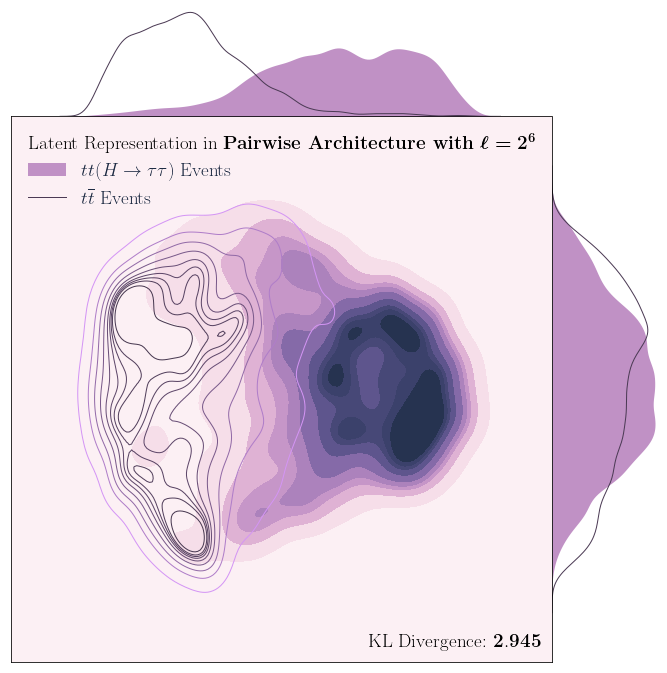

In [35]:
axl64 = gen_tsne(latent64_embedded, latent_label, text=r'Latent Representation in \textbf{Pairwise Architecture with} \boldmath$\mathbf{\ell=2^6}$ ')
axl64.savefig('figures/l64_tsne.pdf')

In [ ]:
axATLAS = gen_tsne(ATLAS_embedded, latent_label, text=r'Latent Representation in \textbf{ATLAS Features}')
axATLAS.savefig('figures/ATLAS_tsne.pdf')

[ 26.258274 -12.141042]
[ 25.772388 -13.17023 ]
KL Divergence 1.7523217802630053


In [33]:
axATLAS

In [ ]:
PI = experiment.Experimenter(filename)
PI.fromSaved(suffix=SUFFIX)

In [ ]:
latent2 = PI.models['latent_two_5_(64, 128, 256, 128, 2)_64']
latent8 = PI.models['latent_eight_5_(64, 128, 256, 128, 8)_64']

X_test, y_test = PI.get_test_dataset('latent_two')
X_test_ATLAS, y_test_ATLAS = gen_dataset_high_level(PI.events_test, PI.events_oup_test, PI.events_tag_test)

n_cut = int(len(X_test)*0.5)
indices = np.random.permutation(len(X_test))
cut = np.s_[indices[:n_cut]]
latent_label = y_test.numpy()[cut]



In [ ]:
latent2_embedded = compute_tsne(latent2, perplexity=50)
latent8_embedded = compute_tsne(latent8)


In [ ]:
ax = gen_tsne(latent2_embedded, latent_label, text=r'Latent Representation in \boldmath$\mathbf{\ell=2^1}$ \textbf{Pairwise Architecture}')
ax.savefig('figures/l2_tsne.pdf')

In [ ]:
ax = gen_tsne(latent8_embedded, latent_label, text=r'Latent Representation in \boldmath$\mathbf{\ell=2^3}$ \textbf{Pairwise Architecture}')
ax.savefig('figures/l8_tsne.pdf')